In [2]:
#basic libraries
import os
import pandas as pd 
import numpy as np
import requests
import json
import glob
import pickle

#Visiualization and ML libraries
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import norm
import statistics
import seaborn as sns
from scipy.stats import f_oneway
import scikit_posthocs as sp
from scipy.stats import kruskal
import statsmodels.stats.multicomp as mc

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler


In [3]:
df_classification = pd.read_csv('/Users/sandrobarreshamers/Thesis_IS_fake_news/ThesisData/Data/Liar_computed_v2.csv')


In [4]:
df_classification.head()

,Unnamed: 0.1,Unnamed: 0,json_id,claim,object,flesch_kincaid_reading_ease,compressed_size,vader_neg,vader_neu,vader_pos,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SYM,pos_VERB,pos_X
0,0,0,10540.json,half-true,When did the decline of coal start? It started...,71.815000,11443.0,0.000,0.902,0.098,...,5.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,4.0,0.0
1,1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",71.781579,9089.0,0.107,0.687,0.206,...,2.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,3.0,0.0
2,2,2,1123.json,false,Health care reform legislation is likely to ma...,53.655000,5511.0,0.000,0.606,0.394,...,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3,3,9028.json,half-true,The economic turnaround started at the end of ...,61.325000,4708.0,0.000,1.000,0.000,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,4,12465.json,true,The Chicago Bears have had more starting quart...,54.096667,12205.0,0.119,0.828,0.053,...,5.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0,3.0,0.0


In [5]:
filtered_df = df_classification[df_classification['binary label'] != 2]

filtered_df.head()
filtered_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'json_id', 'claim', 'object',
       'flesch_kincaid_reading_ease', 'compressed_size', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'binary label',
       'tot_ner_count', 'ner_counts', 'input_vector_ner', 'NER_PERSON',
       'NER_ORG', 'NER_GPE', 'NER_DATE', 'NER_NORP', 'NER_CARDINAL',
       'pos counts', 'input_vector_pos', 'pos_ADJ', 'pos_ADP', 'pos_ADV',
       'pos_AUX', 'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NOUN', 'pos_NUM',
       'pos_PART', 'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ',
       'pos_SYM', 'pos_VERB', 'pos_X'],
      dtype='object')

In [6]:
def count_claims(df, claim):
    count_claim = len(df[df['claim']== claim])
    return count_claim

false_claims = count_claims(filtered_df,'false')
true_claims =  count_claims(filtered_df,'true')
print(f'false claims {false_claims}')
print(f'true claims {true_claims}')

false claims 1994
true claims 1676


In [5]:
features5 = ['flesch_kincaid_reading_ease', 'compressed_size', 'tot_ner_count','NER_PERSON','NER_DATE','NER_CARDINAL','pos_NOUN', 'pos_ADJ',
       'pos_VERB', 'pos_ADV', 'pos_ADP',
       'pos_DET', 'pos_NUM', 'pos_PART', 'pos_PROPN',
       'pos_PUNCT', 'pos_SCONJ']

In [51]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[features5]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Scale the features and normalize the data
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)




In [52]:
class_counts_init = filtered_df['binary label'].value_counts()
print(f'Initial number of train instances: \nLabel : 0(True), counts:{class_counts_init[0]}\nLabel: 1(False), counts:{class_counts_init[1]}\n')

class_counts_over = pd.Series(y_train_resampled).value_counts()
print(f'Number of train instances after oversampling: \nLabel : 0(True), counts:{class_counts_over[0]}\nLabel: 1(False), counts:{class_counts_over[1]}\n')


Initial number of train instances: 
Label : 0(True), counts:1676
Label: 1(False), counts:2833

Number of train instances after oversampling: 
Label : 0(True), counts:2260
Label: 1(False), counts:2260



### Naive Bias 

In [54]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train_res_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
cm =confusion_matrix(y_test, y_pred)


In [58]:
# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Use the cross_val_score function to calculate the accuracy scores for each fold
scores = cross_val_score(model, X_train_res_scaled, y_train_resampled, cv=kfold, scoring='f1_macro')


print("f1 score k fold crss training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss: 0.56 (+/- 0.01)


In [59]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define a scorer with f1 macro
scorer = make_scorer(f1_score, average='macro')

# Perform cross validation
scores = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scorer)

print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross for the test data: 0.57 (+/- 0.03)


### Random forrest

[[121 208]
 [131 442]]


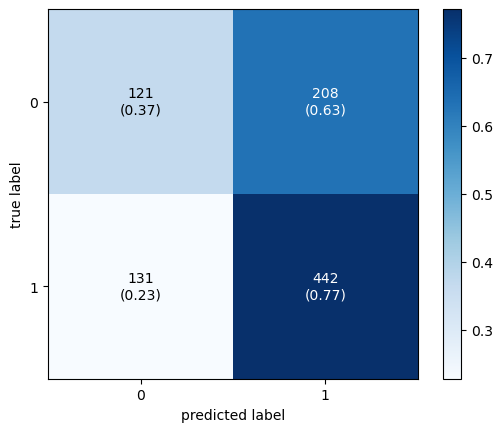

In [35]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res_scaled, y_train_resampled)
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)



cm_2 =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_2,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

# improved from 51% to 55%
print(cm_2)

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train_res_scaled, y_train_resampled, cv=kfold, scoring='f1_macro')

print("f1 score k fold cross training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss: 0.75 (+/- 0.01)


In [23]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define a scorer with f1 macro
scorer = make_scorer(f1_score, average='macro')

# Perform cross validation
scores = cross_val_score(clf, X_test, y_test, cv=kfold, scoring=scorer)

print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross for the test data: 0.54 (+/- 0.02)


### LogisticRegression

In [62]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train_res_scaled, y_train_resampled)

# Evaluate the model on the test data
y_pred_test = logreg.predict(X_test_scaled)
test_score = f1_score(y_test, y_pred_test)
print("Test F1 score:", test_score)

# Evaluate the model on the training data
y_pred_train = logreg.predict(X_train_res_scaled)
train_score = f1_score(y_train_resampled, y_pred_train)
print("Training F1 score:", train_score)


Test F1 score: 0.6641721234798877
Training F1 score: 0.6019629225736095


In [63]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(logreg, X_train_res_scaled, y_train_resampled, cv=kfold, scoring='f1_macro')

print("f1 score k fold cross training data:%0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross training data:0.59 (+/- 0.02)


In [65]:
# Define a scorer with f1 macro
scorer = make_scorer(f1_score, average='macro')

# Perform cross validation
scores = cross_val_score(logreg, X_test_scaled, y_test, cv=kfold, scoring='f1_macro')

print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross for the test data: 0.54 (+/- 0.06)


### Baseline

In [30]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")


dummy_clf.fit(X_train_res_scaled, y_train_resampled)

y_pred_majority = dummy_clf.predict(X_test_scaled)


accuracy_majority = accuracy_score(y_test, y_pred_majority)

Accuracy: 0.3647450110864745


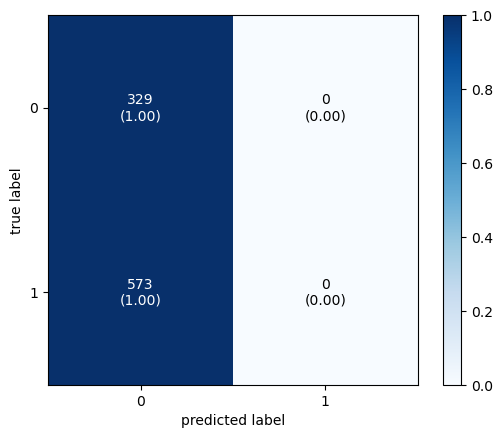

In [31]:
print('Accuracy:', accuracy_majority)

cm_2 =confusion_matrix(y_test, y_pred_majority)
fig, ax = plot_confusion_matrix(conf_mat=cm_2,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)



In [32]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(dummy_clf, X_train_res_scaled, y_train_resampled, cv=kfold, scoring='f1_macro')

print("f1 score k fold cross training data:%0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss:0.33 (+/- 0.01)


In [33]:
# Define a scorer with f1 macro
scorer = make_scorer(f1_score, average='macro')

# Perform cross validation
scores = cross_val_score(dummy_clf, X_test_scaled, y_test, cv=kfold, scoring=scorer)

print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross for the test data: 0.39 (+/- 0.02)


### Gradient Booster

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [39]:
### Gradient booster

              precision    recall  f1-score   support

           0       0.48      0.57      0.52       329
           1       0.72      0.65      0.68       573

    accuracy                           0.62       902
   macro avg       0.60      0.61      0.60       902
weighted avg       0.63      0.62      0.62       902

Accuracy: 0.6175166297117517


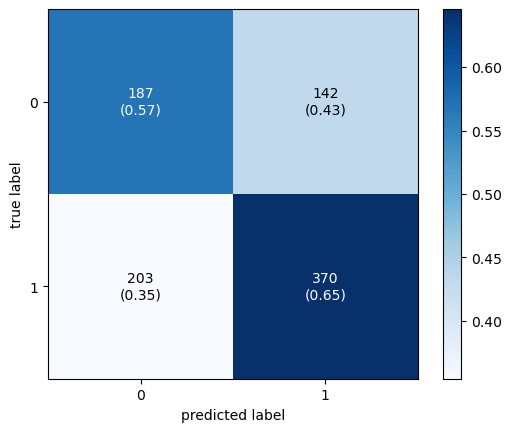

In [42]:
# Instantiate the model with hyperparameters and L2 regularization
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=2, subsample=0.5, random_state=42)


# Fit the model to the training data
gb_clf.fit(X_train_res_scaled, y_train_resampled)

# Predict on the test data
y_pred = gb_clf.predict(X_test_scaled)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))

cm_3 = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_3,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


In [43]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(gb_clf, X_train_res_scaled, y_train_resampled, cv=kfold, scoring='f1_macro')

print("f1 score k fold crss:%0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold crss:0.61 (+/- 0.01)


In [44]:
# Define a scorer with f1 macro
scorer = make_scorer(f1_score, average='macro')

# Perform cross validation
scores = cross_val_score(gb_clf, X_test_scaled, y_test, cv=kfold, scoring=scorer)

print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1 score k fold cross for the test data: 0.53 (+/- 0.04)
